This is intended to test hashing collisions and times

In [8]:
### Prefix Hash Code ###
#Add class name to list at the bottom, to include in testing

#### No Hack Protection ####
# Heavily inspired by Alex Wice's RabinKarp class implementation
class PrefixHash:
    #Input a string encoded as an array (e.g. numbers bounded from 0-26)
    #Initialization is O(n)
    def __init__(self, arr):
        self.mod = mod = 455666777788888999999
        self.base = base = 37
        self.inv = inv = pow(base, mod-2, mod)
        self.pref = pref = [0]
        self.invpref = invpref = [1]
        pwr, invpwr = 1, 1
        hsh = 0
        for x in arr:
            hsh = (hsh+x*pwr)%mod
            pwr = (pwr*base)%mod
            invpwr = (invpwr*inv)%mod
            pref.append(hsh)
            invpref.append(invpwr)
    #Obtain the hash of a substring [l, ... r] in O(1)
    #Inclusive of l and r
    def query(self, l, r):
        return (self.pref[r+1]-self.pref[l])*self.invpref[l]%self.mod

### List of Classes ###
classes = [PrefixHash]

In [9]:
### Utility Methods ###
import random as rd
from time import time
import itertools
import operator

#Generate an array of length n, with values up to k
def generate(n, k=int(1e9), neg=1):
    return [rd.randint((1-k if neg else 1), k) for _ in range(n)]

#Detect hash collision between two substrings
def collide(arr, pref, l1, r1, l2, r2):
    same = pref.query(l1, r1) == pref.query(l2, r2) and arr[l1:r1+1] == arr[l2:r2+1]
    collision = pref.query(l1, r1) == pref.query(l2, r2) and arr[l1:r1+1] != arr[l2:r2+1]
    return (same, collision)

#Create prefix hash and return (prefix, time to create)
def create(arr, c):
    start = time()
    pref = c(arr)
    return (pref, time()-start)

#Perform hash comparisons 
#Return [[comparisons, matches, collisions, portion of collisions] per length of subarray]
def scan(arr, pref):
    n, l1 = len(arr), 0
    tests = []
    start = time()
    for r1 in range(n):
        cur = [0,0,0]
        for l2 in range(1, n-r1, n//100):
            r2 = l2+r1
            cur[0]+=1
            match, collision = collide(arr, pref, l1, r1, l2, r2)
            cur[1]+=match
            cur[2]+=collision
        tests.append(cur + ([cur[2]/cur[0]] if cur[0] else [0.0]))
    return (tests, time()-start)

#Aggregate all comparisons, matches, collisions or collision ratios
aggregate = lambda res, i: sum(map(operator.itemgetter(i), res))

In [10]:
### Testing Methods ###
from operator import add

#Length of test array, max element, negatives allowed
ARR_LEN = int(1e5)
K = 10
NEG=None #default includes negatives

#Amount of tests to run
SAMPLE_SIZE = 10

#Test collisions for a prefix class
def test(c):
    class_name = c.__name__
    arr = generate(ARR_LEN, k=K, neg=NEG)
    pref, time_to_create = create(arr, c)
    results, time_to_query = scan(arr, pref)
    query_amount = aggregate(results, 0)
    match_amount = aggregate(results, 1)
    collision_amount = aggregate(results, 2)
    collision_rate = aggregate(results, 3)/len(results)

    stats = {
        'class_name': class_name,
        'prefix_instance': pref, #Needed for the mod
        'results': results,
        'time_to_create': time_to_create,
        'time_to_query': time_to_query,
        'query_amount': query_amount,
        'match_amount': match_amount,
        'collision_amount': collision_amount,
        'collision_rate': collision_rate
    }
    return stats

#Interpolate stat2 info into stat1
def combine(stat1, stat2):
    if stat1['class_name'] != stat2['class_name']:
        raise ValueError('Tried to combine stats of different classes')
    for idx in range(len(stat1['results'])):
        result = stat1['results'][idx]
        new_result = stat2['results'][idx]
        stat1['results'][idx] = list(map(add, result, new_result))
    stat1['time_to_create']+=stat2['time_to_create']
    stat1['time_to_query']+=stat2['time_to_query']
    stat1['query_amount']+=stat2['query_amount']
    stat1['match_amount']+=stat2['match_amount']
    stat1['collision_amount']+=stat2['collision_amount']
    stat1['collision_rate']+=stat2['collision_rate']
    

#Run SAMPLE_SIZE Tests and return total results
def aggregate_test(c):
    class_name = c.__name__
    for _ in range(SAMPLE_SIZE):
        stats = test(c)
        if class_name not in class_stats:
            class_stats[class_name] = stats
        else:
            total = class_stats[class_name]
            combine(total, stats)
    #Update averages
    total = class_stats[class_name]
    total['time_to_create']/=SAMPLE_SIZE
    total['time_to_query']/=SAMPLE_SIZE
    total['collision_rate']/=SAMPLE_SIZE
            

#Print relevant information on a class
def get_info(stats):
    class_name = stats['class_name']
    pref = stats['prefix_instance']
    time_to_create = stats['time_to_create']
    time_to_query = stats['time_to_query']
    query_amount = stats['query_amount']
    match_amount = stats['match_amount']
    collision_amount = stats['collision_amount']
    collision_rate = stats['collision_rate']
    print('_______' + '_'*len(class_name))
    print(f'Class: {class_name}')
    print(f'Time to create prefix: {time_to_create*1000} ms')
    print(f'Time for {query_amount} queries: {time_to_query*1000} ms')
    print(f'Average time per query: {time_to_query/query_amount*1000} ms')
    print(f'Queries: {query_amount}, Matches: {match_amount}, Collisions: {collision_amount}')
    print(f'Expected amount of collisions: {query_amount/pref.mod}')
    print(f'Overall collision rate: {collision_rate*100}%')
    print(('_______' + '_'*len(class_name))*3)

#Run Tests

#Info about each class
class_stats = {}

for c in classes:
    aggregate_test(c)

In [11]:
### Display Info ###

for stats in class_stats.values():
    get_info(stats)

_________________
Class: PrefixHash
Time to create prefix: 25.952768325805664 ms
Time for 50499000 queries: 3740.3335571289062 ms
Average time per query: 7.40674777149826e-05 ms
Queries: 50499000, Matches: 101, Collisions: 0
Expected amount of collisions: 1.1082440603865189e-13
Overall collision rate: 0.0%
___________________________________________________


In [293]:
### Visualization Methods ###
from matplotlib import pyplot as plt
import numpy as np

def visualize_collisions_by_length(results, bar_amount=1000):
    x_labels = [f'{i*10}-{(i+1)*10-1}' for i in range(len(arr_parts))]
    arr_parts = np.array_split(list(map(operator.itemgetter(3), results)), bar_amount)
    percentages = [np.average(part)*100 for part in arr_parts]
    plt.bar(x_labels, percentages)
    plt.xlabel('Index Range')
    plt.ylabel('Collision Rate (%)')
    plt.title('Collision Rate by Comparison Length')
    plt.show()



def visualize_collisions_by_class(class_stats):
    x_labels = list(class_stats.keys())
    percentages = list()
    plt.bar(x_labels, percentages)
    plt.xlabel('Prefix Augmentat')
    plt.ylabel('Collision Rate (%)')
    plt.title('Collision Rate by Prefix Class')
    plt.show()

visualize_collisions_by_class(class_stats)
        

<class 'list'>


In [ ]:
### Collisions by Class ###
visualize_collisions_by_class(class_stats)

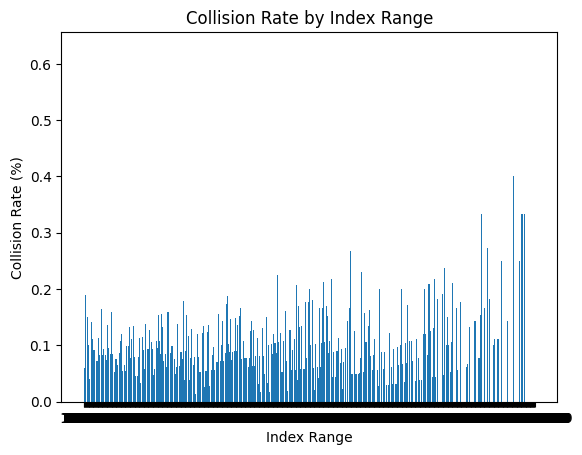

In [294]:
### Collisions by comparison length ###
for stats in class_stats.values():
    visualize_collisions_by_length(stats['results'])

In [21]:
from math import sqrt

def is_prime(x):
    if not x&1: return 0
    return all(x%y for y in range(3, int(sqrt(x)+1), 2))

#Center with which to compare, amount of time to take
def generate_primes(center, t=15):
    start = time()
    global l
    global r
    l, r = center, center+1
    res = []
    while time()-start<t:
        if l>1 and is_prime(l): res.append(l)
        if is_prime(r): res.append(r)
        l-=1
        r+=1
    return res

#Hand-Picked Large Primes
large_primes = [
    1234567894987654321, #1->9, 4, 9->1
    89999999999999999999, #9e20 - 1
    99999999999999999989, #1e21 - 11
    44444444443333332221, #4->1, repeated triangular[i] times
    135313531353135313531, #'13531' folded out 5 times
    455666777788888999999, #one 4, two 5s, 3 6s, etc.
    457000000000000000001, #457e18 + 1
    555555555551111111111, #11 5's then 5 11's
    877666555544444333333, #one 8, two 7s, 3 6s, etc.
    900000000080000000009, #9 0's between each 9
    944446666669999999999, #4 4's, 6 6's, 9 9's sandwiched by two 9's
    975319753197531975319, #descending odd digits 4 times, plus 9
    1999999999999999999979, #2e21 - 21
    11111111111111111111111, #'1'*23
    11111111111111111111117, #'1'*23+6
    70000000000000000000003, #7*3 (21) 0's between them
]

In [24]:
for prime in large_primes:
    print(f'{prime}: {is_prime(prime)}')

1234567894987654321: True
89999999999999999999: True
99999999999999999989: True
44444444443333332221: True
135313531353135313531: True
455666777788888999999: True
457000000000000000001: True
555555555551111111111: True
877666555544444333333: True
900000000080000000009: True
944446666669999999999: True
975319753197531975319: True
1999999999999999999979: True
11111111111111111111111: True
11111111111111111111117: True
